In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import models, layers, mixed_precision

train_dir = "/kaggle/input/histopathologic-cancer-detection/train"
test_dir = "/kaggle/input/histopathologic-cancer-detection/test"


2.12.0


In [3]:
print("Training Number: ", len(os.listdir(train_dir)))
print("Test Number: ", len(os.listdir(test_dir)))

Training Number:  220025
Test Number:  57458


In [4]:
df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [23]:
df.label = df.label.astype(str)
df.id = df.id + ".tif"
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB
None


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [5]:
print("Number of Images:",len(df))
print("Ratio of labels :", sum(df['label'].values)/len(df))
img = plt.imread("/kaggle/input/histopathologic-cancer-detection/train/"+df.iloc[0]['id']+'.tif')
print('Images shape', img.shape)

Number of Images: 220025
Ratio of labels : 0.40503124644926713
Images shape (96, 96, 3)


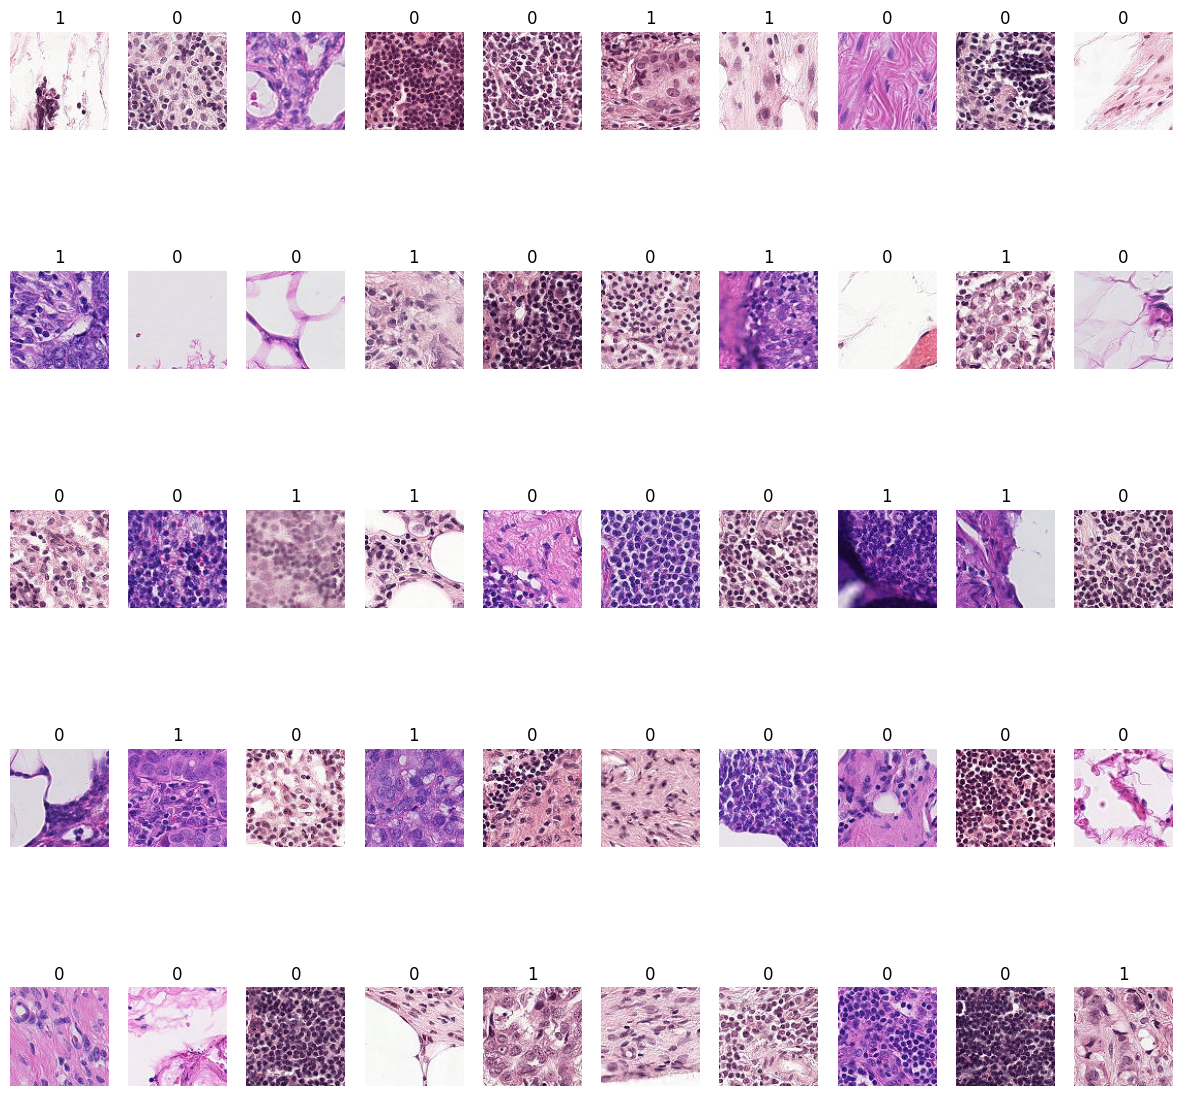

In [6]:
w = 10
h = 10
fig = plt.figure(figsize=(15, 15))
columns = 10
rows = 5
for i in range(1, columns*rows +1):
    img = plt.imread("/kaggle/input/histopathologic-cancer-detection/train/"+df.iloc[i]['id']+'.tif')
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title(df.iloc[i]["label"])
    plt.imshow(img)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# Define the path to your images
image_paths = [os.path.join(train_dir, filename+'.tif') for filename in df['id']]

# Define the labels
labels = df['label'].values

# Split the data into training and validation sets
train_paths, valid_paths, train_labels, valid_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

print("Number of training samples:", len(train_paths))
print("Number of validation samples:", len(valid_paths))


Number of training samples: 176020
Number of validation samples: 44005


Image shape:  (96, 96, 3)
Label:  0


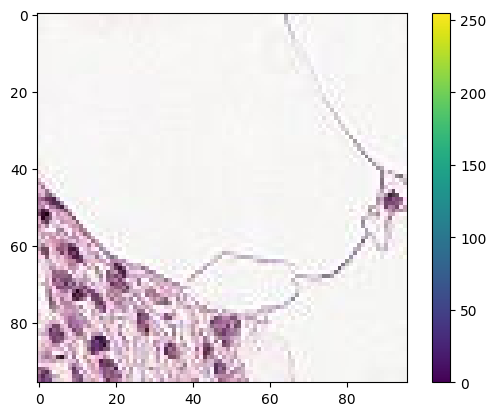

In [8]:
plt.figure()
img = plt.imread("/kaggle/input/histopathologic-cancer-detection/train/"+ df.iloc[0]["id"]+'.tif')
print("Image shape: ", img.shape)
print("Label: ", df.iloc[0]["label"])
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_train_val_generator(train_datagen, df, sample_frac=1.0, bs=64):
    df = df.sample(frac=sample_frac, random_state=42)
    
    train_generator = train_datagen.flow_from_dataframe(dataframe=df,
                                                       directory=train_dir,
                                                       x_col="id",
                                                       y_col="label",
                                                       subset="training",
                                                       target_size=(96, 96),
                                                       batch_size=bs,
                                                       class_mode="binary")
    valid_generator = train_datagen.flow_from_dataframe(dataframe=df,
                                                       directory=train_dir,
                                                       x_col="id",
                                                       y_col="label",
                                                       subset="validation",
                                                       target_size=(96, 96),
                                                       batch_size=bs,
                                                       shuffle=False,
                                                       class_mode="binary")
    return train_generator, valid_generator

In [25]:
train_datagen = ImageDataGenerator(validation_split=0.2)
train_generator, valid_generator = get_train_val_generator(train_datagen, df, sample_frac=0.3)

Found 52807 validated image filenames belonging to 2 classes.
Found 13201 validated image filenames belonging to 2 classes.


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the input shape based on the shape of your images
input_shape = (img.shape[0], img.shape[1], img.shape[2])

# Initialize the CNN model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output for dense layers
model.add(Flatten())

# Dropout Layer to prevent overfitting
model.add(Dropout(0.5))

# Fully Connected Layer
model.add(Dense(128, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))  # for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 10, 10, 128)     

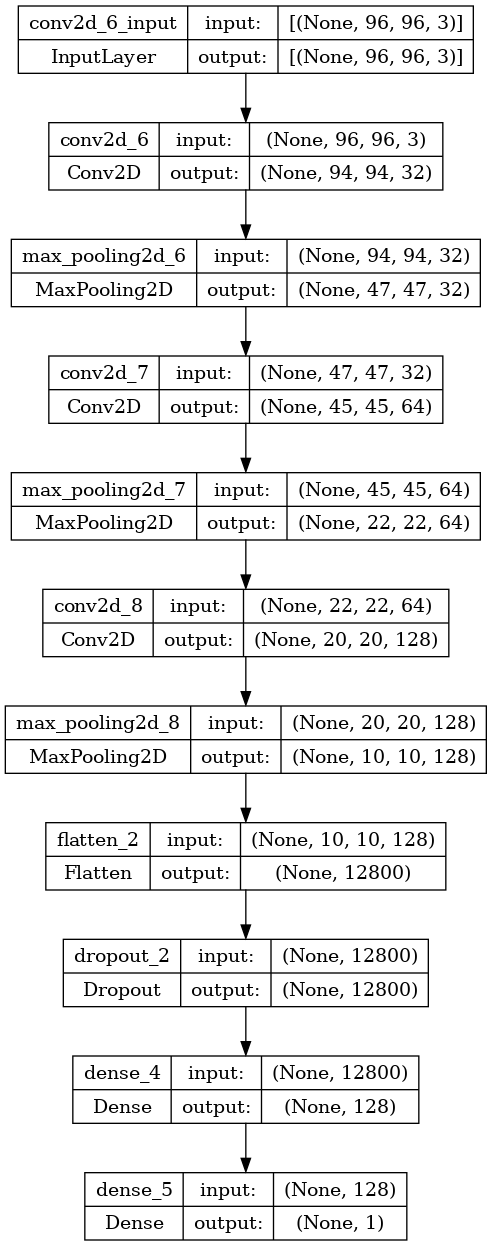

In [34]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
model.compile(
    optimizer='adam',  # You can choose another optimizer if needed
    loss='binary_crossentropy',  # Assuming binary classification
    metrics=['accuracy']  # You can add more metrics as needed
)

In [29]:
# Define the number of epochs and batch size
epochs = 10
batch_size = 32

# Train the model
history = model.fit(
    train_generator,  # Your training data generator (e.g., train_data)
    epochs=epochs,
    validation_data=valid_generator,  # Your validation data generator (e.g., valid_data)
    verbose=1  # Set to 1 for progress updates during training
)

Epoch 1/10
826/826 [==============================] - 416s 485ms/step - loss: 0.9975 - accuracy: 0.7239 - val_loss: 0.4631 - val_accuracy: 0.7893
Epoch 2/10
826/826 [==============================] - 120s 145ms/step - loss: 0.4726 - accuracy: 0.7847 - val_loss: 0.4735 - val_accuracy: 0.7694
Epoch 3/10
826/826 [==============================] - 119s 144ms/step - loss: 0.4869 - accuracy: 0.7757 - val_loss: 0.4794 - val_accuracy: 0.7931
Epoch 4/10
826/826 [==============================] - 120s 145ms/step - loss: 0.4510 - accuracy: 0.7932 - val_loss: 0.4213 - val_accuracy: 0.8105
Epoch 5/10
826/826 [==============================] - 120s 145ms/step - loss: 0.4367 - accuracy: 0.8027 - val_loss: 0.4005 - val_accuracy: 0.8170
Epoch 6/10
826/826 [==============================] - 122s 147ms/step - loss: 0.4214 - accuracy: 0.8114 - val_loss: 0.3947 - val_accuracy: 0.8241
Epoch 7/10
826/826 [==============================] - 120s 145ms/step - loss: 0.3887 - accuracy: 0.8310 - val_loss: 0.3523 -

In [31]:
def plt_performance(train, valid, title):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 1, 1)
    plt.plot(train, label='Training')
    plt.plot(valid, label='Validation')
    plt.legend(loc='upper left')
    plt.ylim([min(plt.ylim())-0.1,max(plt.ylim())+0.1])
    plt.title(title)

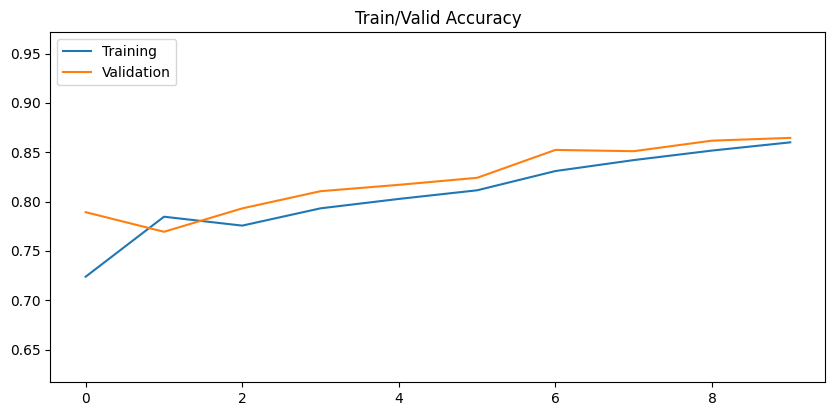

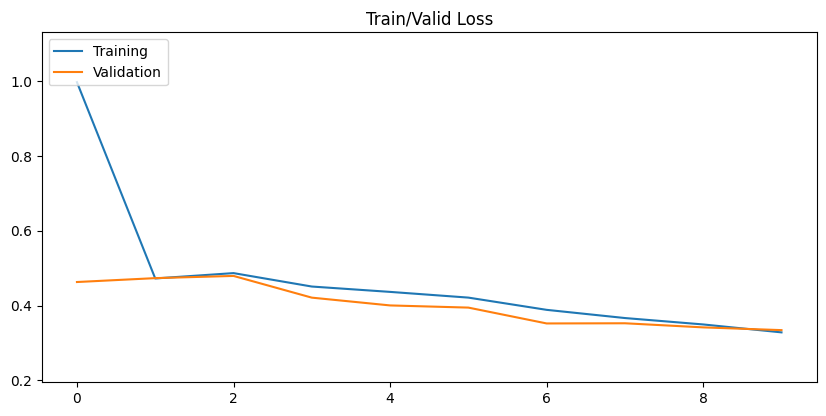

In [32]:
plt_performance(history.history["accuracy"], history.history["val_accuracy"], "Train/Valid Accuracy")
plt_performance(history.history["loss"], history.history["val_loss"], "Train/Valid Loss")

In [36]:
df_test = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
df_test.id = df_test.id + ".tif"
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe=df_test,
                                                        directory=test_dir,
                                                        x_col="id",
                                                        y_col=None,
                                                        target_size=(96, 96),
                                                        batch_size=2,
                                                        shuffle=False,
                                                        class_mode=None)

test_generator.reset()
preds = model.predict(test_generator,verbose=1)

Found 57458 validated image filenames.
28729/28729 [==============================] - 569s 20ms/step


In [37]:
submission = pd.DataFrame()
submission['id'] = df_test['id'].apply(lambda x: x.split('.')[0])
submission['label'] = preds[:, 0]
submission.to_csv('submission.csv', index=False)
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.068936
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.636458
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.008148
3,2c35657e312966e9294eac6841726ff3a748febf,0.258319
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.071595
